In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style(style='darkgrid') 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Scrubbing and initial exploration of data

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [3]:
# Removing columns that aren't required for modeling
cols_to_drop = ['id']
df.drop(columns=cols_to_drop, inplace=True)

In [4]:
# checking missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 3.3+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['zipcode'] = df['zipcode'].astype('category')
for col in ['yr_built', 'yr_renovated']:
    df[col] = pd.to_datetime(df[col]).dt.to_period('Y')


In [6]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,47.777600,-121.315000,6210.000000,871200.000000


# Outliers, Normality Checks, Categorical Variables 

In order to keep track of which variables will be transformed, let's create a "to_normalize" list and store features in it along the way

In [7]:
to_normalize = []
categorical = []

## Dependent Variable

In [8]:
def dep_var_dist(dependent_variable ='price', df=df, logtransform=False):
    log_trans = ''
    if logtransform:
        df = df.apply(np.log)
        log_trans = 'Log Transformed '

    # dependent variable PRICE

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    f.suptitle('Distribution of '+ log_trans + dependent_variable.title() + ' Data', x=0.52, y=1, fontsize=16)

    plt.subplots_adjust(hspace=0.3)

    data = df[dependent_variable]
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title('Boxplot', fontsize=12)
    ax1.set_xlabel('')


    sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)


    ax2.set_title('Distplot', fontsize=12)
    ax2.set_xlabel(dependent_variable)
    plt.show()

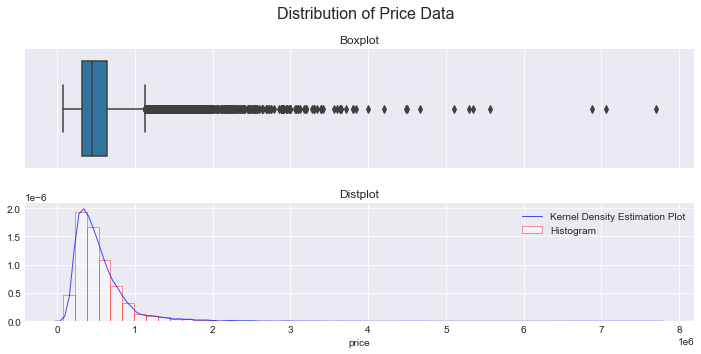

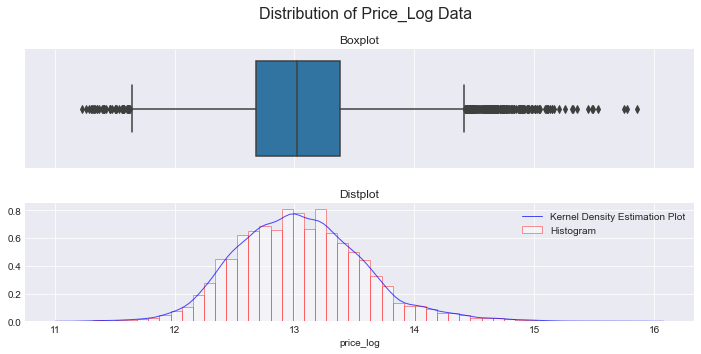

In [9]:
# plots dependent variable as is
dep_var_dist()

# plots log transformed Dep Variable
data = df[['price']]
data['price_log'] = data['price'].apply(np.log)
dep_var_dist(dependent_variable='price_log', df=data)


The variable 'price' is somewhat normal, even though it is strongly skewed by outliers. The distribution becomes less skewed if we look at log transformed price

## Independent Variables

In [11]:
to_normalize = []
categorical = []
X_cols = []

In [12]:
def check_distribution(cols, df=df):
    
    
    for col in cols:
        fig, axes = plt.subplots(2, 
                                 sharex='col',  gridspec_kw={"height_ratios": (.15, .85)}, 
                                 figsize = (15,5))
        fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
        
        # top  plot
        sns.boxplot(x=df[col], ax = axes[0],color = 'red')
        axes[0].set_title('Boxplot', fontsize=12)
        axes[0].set_xlabel('')
        
        # middle plot
        sns.distplot(df[col], hist=True, 
                     hist_kws={"linewidth": 1, "edgecolor" :'red', "alpha": 0.4,
                               "color":  "w", "label": "Histogram"},
                     kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                          "alpha": 0.7, 'label':'Kernel Density Estimation Plot'},
                     fit= stats.norm, 
                     fit_kws = {'color' : 'green', 'label' : 'parametric fit',
                                "alpha": 0.7, 'linewidth':3},
                 ax=axes[1])
        axes[1].set_title('Density Estimations', fontsize=12)
        axes[1].set_ylabel('frequency/probability')
        axes[1].set_xlabel(col)
        axes[1].legend()
        plt.show()
    

### sqft_living

it is .....

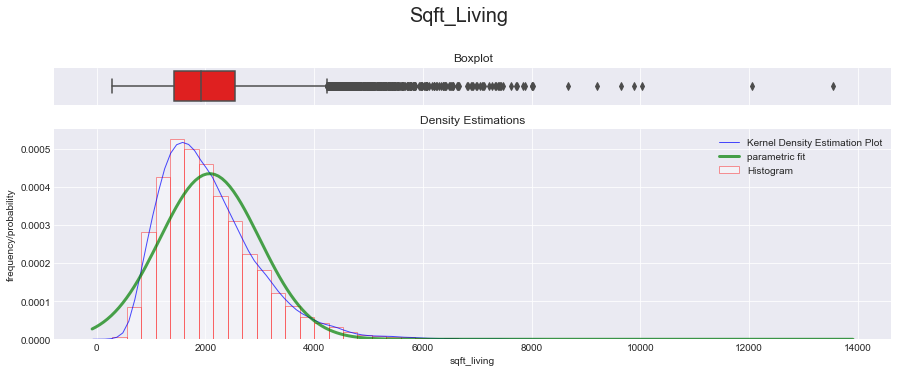

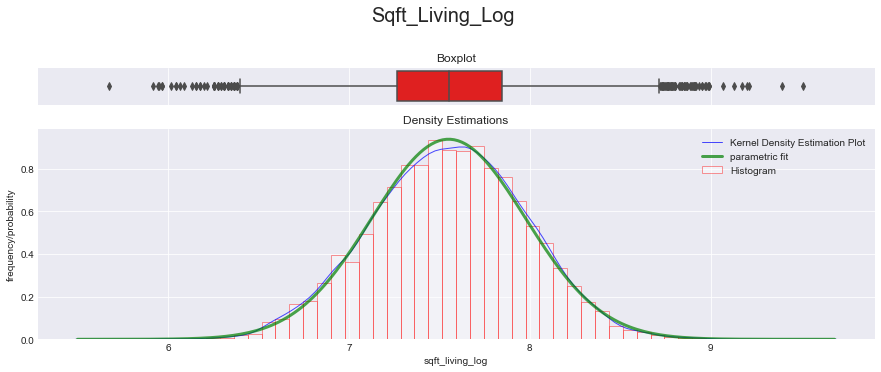

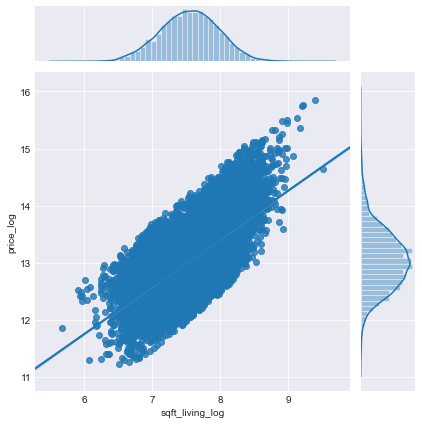

In [18]:
# distributions as is
check_distribution(cols=['sqft_living'], df=df)

# distributions of log tranformed variable
data = df[['sqft_living', 'price']].apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_living_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_living_log', y='price_log', data=data, kind='reg')

- there is a clear linear relationship price and sqft_living
- log transformation was effective in controlling the effects of outliers and normalizing distributions

In [19]:
for l in [to_normalize, X_cols]:
    l.append('sqft_living')

### sqft_living15

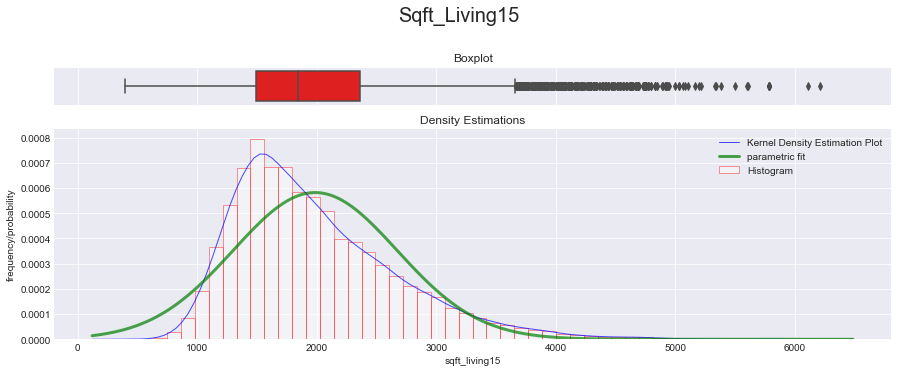

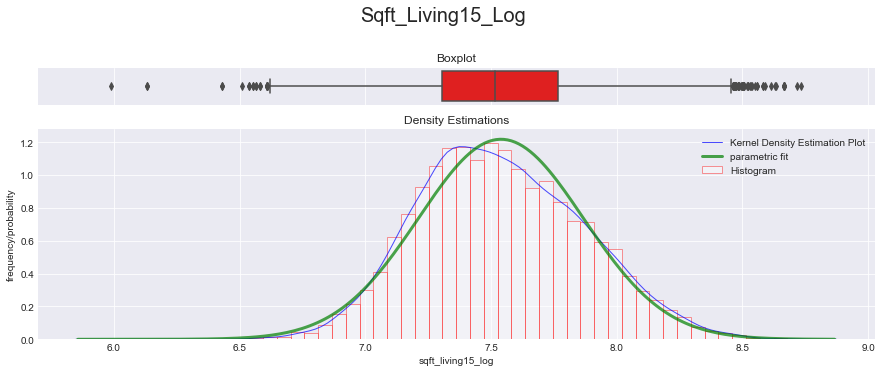

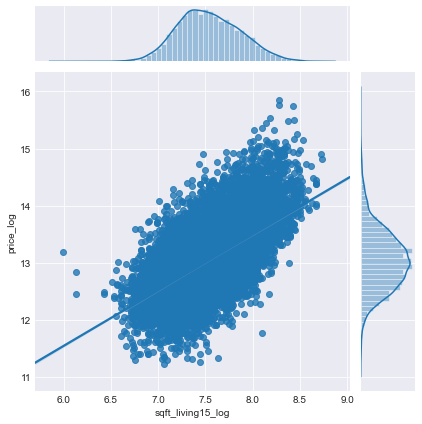

In [23]:
# distributions as is
check_distribution(cols=['sqft_living15'], df=df)

# distributions of log tranformed variable
data = df[['sqft_living15', 'price']].apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_living15_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_living15_log', y='price_log', data=data, kind='reg')

### sqft_above

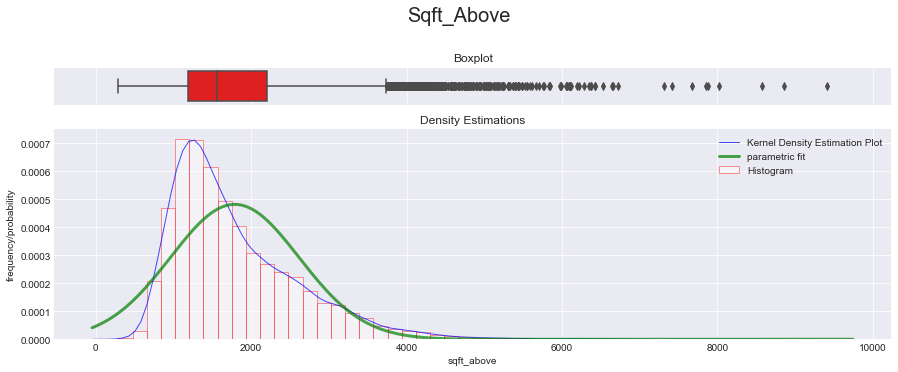

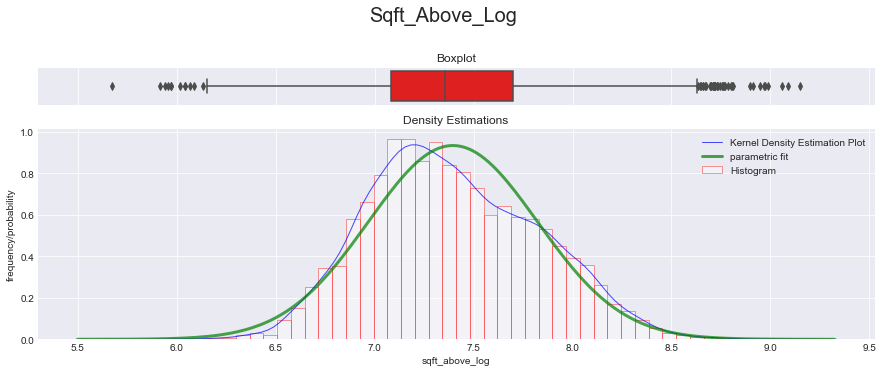

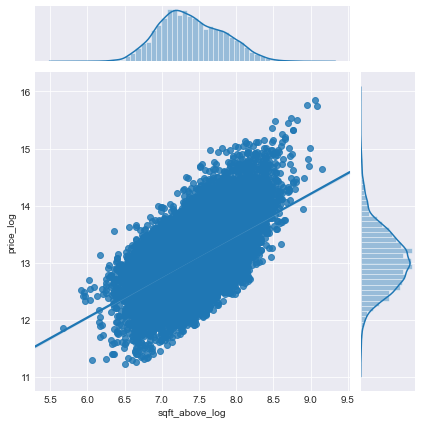

In [24]:
# distributions as is
check_distribution(cols=['sqft_above'], df=df)

# distributions of log tranformed variable
data = (df[['sqft_above', 'price']]+1).apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_above_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_above_log', y='price_log', data=data, kind='reg')

### sqft_basement

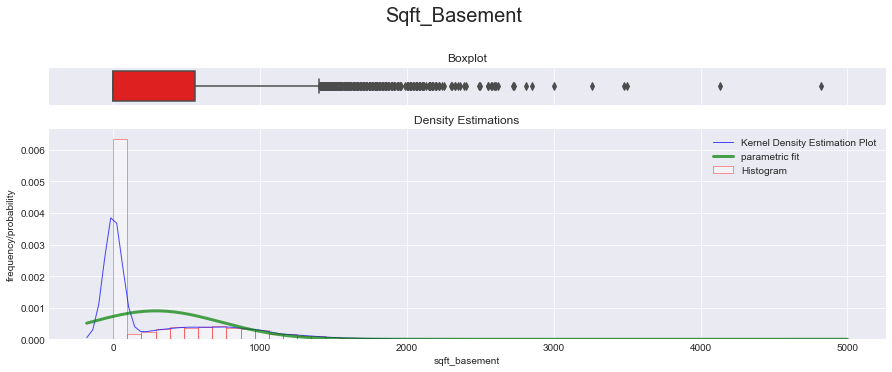

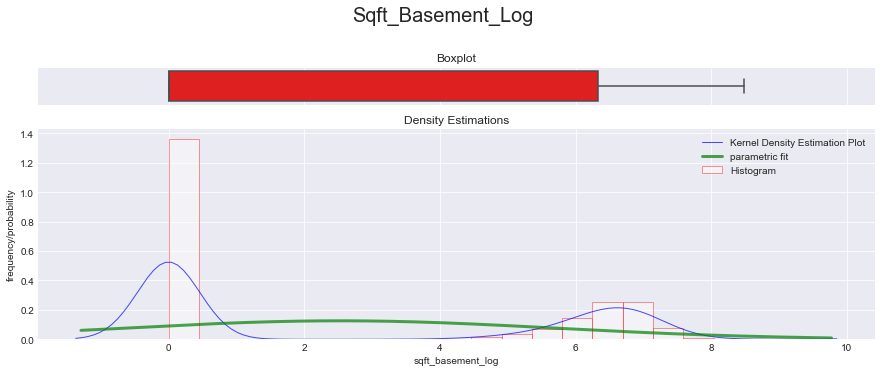

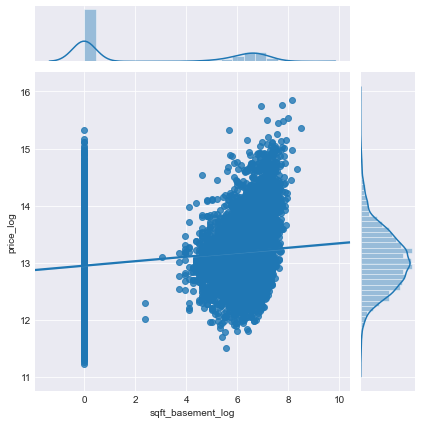

In [25]:
# distributions as is
check_distribution(cols=['sqft_basement'], df=df)

# distributions of log tranformed variable
data = (df[['sqft_basement', 'price']]+1).apply(np.log)
data.columns = [col + '_log' for col in data.columns]
check_distribution(cols=['sqft_basement_log'], df=data)

# jointplot of log transformed dependent and independent variables
a = sns.jointplot(x='sqft_basement_log', y='price_log', data=data, kind='reg')

### Sqft_lot

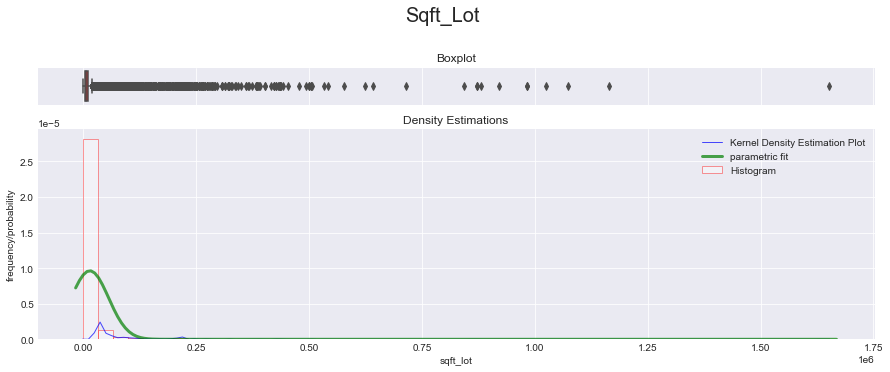

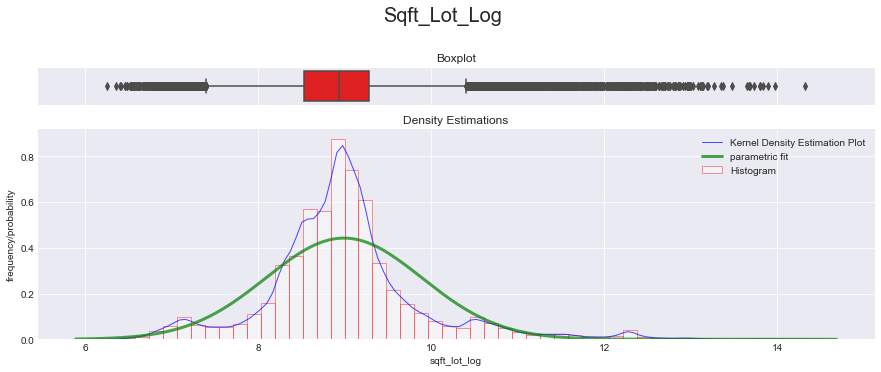

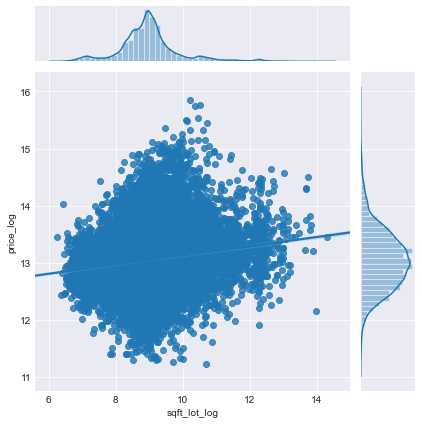

In [28]:
# distribution of lot areas - as is
data = df[['sqft_lot', 'price']]
check_distribution(cols=['sqft_lot'], df=data)

# distribution of lot areas - log transformed 
data = (data+1).apply(np.log)
data.columns = [col+'_log' for col in data.columns]

check_distribution(cols=['sqft_lot_log'], df=data)

a = sns.jointplot(x='sqft_lot_log', y='price_log', data=data, kind='reg')

In [ ]:
for l in [to_normalize, X_cols]:
    l.append('sqft_lot')

### Zip-codes

We shall investigate the distribution of price and price\sqft in each zip-code. It will provide us with a first impression on the relationship between outliers and zip-codes.

In [ ]:
# zip-codes boxplots of price 
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[['sqft_living', 'zipcode', 'price']]

a = sns.boxplot(x=data['price'], orient='v', ax=axes[0])

b = sns.boxplot(x="zipcode", y=('price'), data=data, ax=axes[1])
b.set_title("Price Distribution by Zip-Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- All zip-code price distributions are heavily influenced by outliers
- A few zip-code price distributions are almost entirely inside the outliers are of the overall distribution. This one  indication that outliers are not incorrect data

In [ ]:
# boxplots of price/sqft for each zip-code
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[['price', 'sqft_living']].apply(np.log)
data['zipcode'] = df['zipcode']

a = sns.boxplot(x=data['price'], orient='v', ax=axes[0])

b = sns.boxplot(x="zipcode", y=('price'), data=data, ax=axes[1])
b.set_title("Log Transformed Price Distribution by Zip-Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

- the log transformation and has diminished the impact of outliers on all distributions
- zip-codes are clearly a categorical variable

In [ ]:
for l in [categorical, X_cols]:
    l.append('zipcode')

### Bedrooms

In [ ]:
data = df[['bedrooms']]

check_distribution(cols=['bedrooms'], df=data)

- distribution is heavily influenced by outliers

In [ ]:
data = df[['bedrooms']]
data['bedrooms_log'] = (data['bedrooms']+1).apply(np.log)

check_distribution(cols=['bedrooms_log'], df=data)

- the influence of outliers on the distribution was diminished by the log transformation
- Distribution looks normal enough

Let's plot bedrooms/sqft against price to see if there are obvious signs of multicollinearity 

In [ ]:
data = (df[['price', 'bedrooms']]+1).apply(np.log)

sns.jointplot(x='bedrooms', y='price', data=data, kind='reg')
plt.show()

- clear positive correlation, although common sense points toward collinearity between n of bedrooms and sqft_living

In [ ]:
for l in [to_normalize, X_cols]:
    l.append('bedrooms')

### Bathrooms

In [ ]:
data = df[['bathrooms', 'sqft_living']]

check_distribution(cols=['bathrooms'], df=data)

- Assuming that a reasonable top threshold for bathrooms per square feet is 0.005, there are no outliers in the distribution.
- distribution looks somewhat normal, even though it is skewed

In [ ]:
data = (df[['bathrooms', 'price']]+1).apply(np.log)
data.columns = [col+"_log" for col in data.columns]

check_distribution(cols=['bathrooms_log'], df=data)

- the influence of outliers on the distribution was diminished by the log transformation
- Distribution looks normal enough

In [ ]:
sns.jointplot(x='bathrooms_log', y='price_log', data=data, kind='reg')

- positive linear correlation is observed

In [ ]:
for l in [to_normalize, X_cols]:
    l.append('bathrooms')

### Floors

In [ ]:
sns.jointplot(x='floors', y='price', data=df, kind='reg')

In [ ]:
data = df[['floors', 'price']].apply(np.log)
data.columns = [col+'_log' for col in data.columns]
sns.jointplot(x='floors_log', y='price_log', data=data, kind='reg')

### waterfront

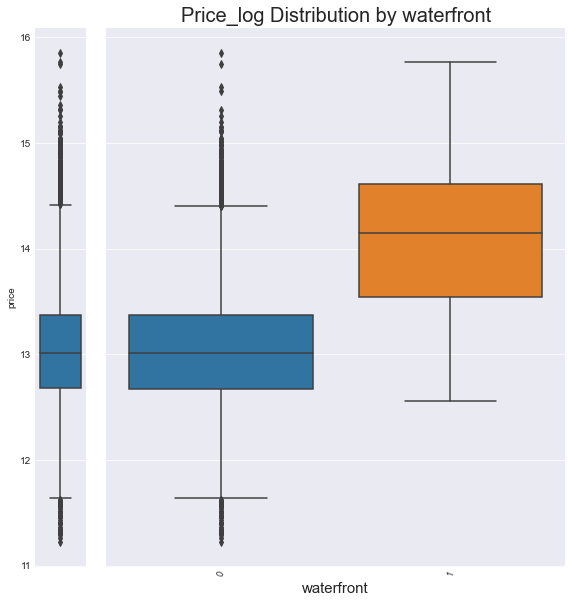

In [29]:
# zip-codes boxplots of price
f, axes = plt.subplots(1, 2, figsize=(8,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[['waterfront', 'price']]

a = sns.boxplot(x=data['price'].apply(np.log), orient='v', ax=axes[0])

b = sns.boxplot(x=data['waterfront'], y=data['price'].apply(np.log), ax=axes[1])
b.set_title("Price_log Distribution by waterfront",fontsize=20)
b.set_xlabel("waterfront",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

In [ ]:
for l in [categorical, X_cols]:
    l.append('waterfront')

# Multicollinearity

In [ ]:
check_distribution()

In [ ]:
for col in df.columns:
    zeros = (df[col] == 0).sum()
    if zeros:
        print(col, zeros)

In [ ]:
df[df['bedrooms'] == 0]

 First look into our dependent and independent variables

In [ ]:
# dependent variable PRICE

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
f.suptitle('Distribution of Price Data', x=0.52, y=1, fontsize=16)

plt.subplots_adjust(hspace=0.3)

data = df['price']
sns.boxplot(x=data, ax=ax1)
ax1.set_title('Boxplot', fontsize=12)
ax1.set_xlabel('')


sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)


ax2.set_title('Distplot', fontsize=12)
plt.show()


# dependent variable PRICE/SQFT

data = (df['price'] / df['sqft_living']).values
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
f.suptitle('Distribution of Price/Sqft Data', x=0.52, y=1, fontsize=16)

plt.subplots_adjust(hspace=0.3)


sns.boxplot(x=data, ax=ax1)
ax1.set_title('Boxplot', fontsize=12)
ax1.set_xlabel('')


sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)

ax2.set_xlabel('price/sqft')
ax2.set_title('Distplot', fontsize=12)
plt.show()





Both distribution are positively skewed, but PRICE is more affected by large outliers than PRICE/SQFT


A second quick check is to visualize the price distribution for each zipcode. This will help see how much outliers can be explained by the property's location

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[['price', 'sqft_living', 'zipcode']]
data['price/sqft'] = df['price']/df['sqft_living']


a = sns.boxplot(x=data['price/sqft'], orient='v', ax=axes[0])

b = sns.boxplot(x="zipcode", y=('price/sqft'), data=data, ax=axes[1])
b.set_title("Price Distribution by Zip Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

Even though the price\sqft distribution of a few zip-codes explain some of the outliers in the general distribution, all zip-codes contain outliers themselves. 

Let's now investigate the distributions of the independent variables

In [ ]:
def check_distribution(df, cols):
    
    
    for col in cols:
        fig, axes = plt.subplots(2, 
                                 sharex='col',  gridspec_kw={"height_ratios": (.15, .85)}, 
                                 figsize = (15,5))
        fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
        
        # top  plot
        sns.boxplot(x=df[col], ax = axes[0],color = 'red')
        axes[0].set_title('Boxplot', fontsize=12)
        axes[0].set_xlabel('')
        
        # middle plot
        sns.distplot(df[col], hist=True, 
                     hist_kws={"linewidth": 1, "edgecolor" :'red', "alpha": 0.4,
                               "color":  "w", "label": "Histogram"},
                     kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                          "alpha": 0.7, 'label':'Kernel Density Estimation Plot'},
                     fit= stats.norm, 
                     fit_kws = {'color' : 'green', 'label' : 'parametric fit',
                                "alpha": 0.7, 'linewidth':3},
                 ax=axes[1])
        axes[1].set_title('Density Estimations', fontsize=12)
        axes[1].set_ylabel('frequency/probability')
        axes[1].set_xlabel(col)
        axes[1].legend()
        plt.show()
        ################
        fig2, axes2 = plt.subplots(1, 2, 
                                   sharey='row', 
                                   gridspec_kw={"width_ratios": (.1, .9)}, 
                                   figsize = (12.3,5) )
        fig2.tight_layout()
        # bottom left plot
        sns.boxplot(y="price/sqft", data=df, ax=axes2[0])
        #axes2[0].set_xticks([])
        axes2[0].set_xlabel('')
        axes2[0].set_title('Price/sqft Boxplot', fontsize=12)




        # bottom right plot
        axes2[1].scatter(df[col], df["price/sqft"],alpha=.051)
        axes2[1].set_xlabel(col)
        axes2[1].set_ylabel('')

        #plt.legend();
        plt.show()
    

In [ ]:
def ks_plot(data, distribution=stats.norm):
    
    std = data.std()
    loc = data.mean()
    min_ = data.min()
    max_ = data.max()
    x = np.linspace(loc-4*std, loc+4*std, len(data))
    
    y = distribution.cdf(x, loc=loc, scale=std)

    plt.figure(figsize=(10,4))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data)))
    plt.plot(x, y)
    plt.legend(['ECDF', 'CDF'])
    plt.title('Comparing CDFs for K-S test, Sample size=' + str(len(data)))
    return

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
#plt.title('Distribution of Price Data')
plt.subplots_adjust(hspace=0.6)

data = np.sort(df['price'].apply(np.log))

sns.boxplot(x=data, ax=ax1)
sns.distplot(data, kde=True, hist=True,
            hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
            kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'})
ax1.set_title('Distribution of Log Price Data', fontsize=15)

plt.show()


ks_plot(data)


# K-S test to test normality
d_stat, p_value =  stats.kstest(data, 'norm')
print('d_stat:', d_stat)
print('p_value:', p_value)



In [ ]:
df['price/sqft'] = df['price'] / df['sqft_living']

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
#plt.title('Distribution of Price Data')
plt.subplots_adjust(hspace=0.6)


data = df["price/sqft"].values

sns.boxplot(x=data, ax=ax1)
sns.distplot(data, kde=True, hist=True)
ax1.set_title('Distribution of Price/Sqft Data', fontsize=15)

plt.show()


ks_plot(data)

# K-S test to test normality
d_stat, p_value =  stats.kstest(data, 'norm')
print('d_stat:', d_stat)
print('p_value:', p_value)


In [ ]:

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
#plt.title('Distribution of Price Data')
plt.subplots_adjust(hspace=0.6)


data = df["price/sqft"].apply(np.log)

sns.boxplot(x=data, ax=ax1)
sns.distplot(data, kde=True, hist=True)
ax1.set_title('Distribution of Price/Sqft Data', fontsize=15)

plt.show()


ks_plot(data)

# K-S test to test normality
d_stat, p_value =  stats.kstest(data, 'norm')
print('d_stat:', d_stat)
print('p_value:', p_value)


In [ ]:
plt.figure(figsize=(13,8))

b = sns.boxplot(x="zipcode", y=('price'), data=df)
plt.title("Price Distribution by Zip Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("price",fontsize=15)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

In [ ]:
plt.figure(figsize=(13,8))
data = df[['price', 'sqft_living', 'zipcode']]
data['price/sqft'] = df['price']/df['sqft_living']
b = sns.boxplot(x="zipcode", y=('price/sqft'), data=data)
plt.title("Price Distribution by Zip Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("price",fontsize=15)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

In [ ]:
import scipy.stats as stats

not_to_plot = ['coord', 'id', 'price', 'date', 'zipcode','lat', 'long', 'price' ]
to_plot = [col for col in df.keys() if col not in not_to_plot]

for col in to_plot:
    
    fig, axes = plt.subplots(2, sharex='col', 
                                  gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,5) )
    fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
    
    
    
    # top  plot
    sns.boxplot(x=df[col], ax = axes[0],color = 'red')
    axes[0].set_title('Boxplot', fontsize=12)
    axes[0].set_xlabel('')

    
    # middle plot
    sns.distplot(df[col], 
                 hist=True, 
                 hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                           "color":  "w", "label": "Histogram"},
                 kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                      "alpha": 0.7,
                                      'label':'Kernel Density Estimation Plot'},
                 fit= stats.norm, fit_kws = {'color' : 'green',
                                         'label' : 'parametric fit',
                                         "alpha": 0.7,
                                          'linewidth':3},
                 ax=axes[1])
    
    
    axes[1].set_title('Density Estimations', fontsize=12)
    axes[1].set_ylabel('frequency/probability')
    axes[1].set_xlabel(col)
    axes[1].legend()
    
    plt.show()
    
    
    ################
    fig2, axes2 = plt.subplots(1, 2, sharey='row', 
                             gridspec_kw={"width_ratios": (.1, .9)}, figsize = (12.3,5) )
    fig2.tight_layout()
    # bottom left plot
    sns.boxplot(y="price/sqft", data=df, ax=axes2[0])
    #axes2[0].set_xticks([])
    axes2[0].set_xlabel('')
    axes2[0].set_title('Price/sqft Boxplot', fontsize=12)

    
    
    
    # bottom right plot
    axes2[1].scatter(df[col], df["price/sqft"],alpha=.051)
    axes2[1].set_xlabel(col)
    axes2[1].set_ylabel('')

    #plt.legend();
    plt.show()

In [ ]:


def create_colinearity_df(correlation_hurdle, variables_list, df):
    """Function that finds which variables have correlation above a 
    certain threshold.
    
    ***
    Function takes in as arguments a correlation hurdle, a list of variables 
    and a Data Frame.
    
    Returns a correlation matrix as a pandas Data Frame
    ***
    Arguments:
    - correlation_hurdle : float between 0 and 1
    - variables_list: list of strings with variable names. Must be a column 
    name of the provided data frame
    - df : a DataFrame containing the data for the variables.
    
    """
    
    # creates a new df from a correlation matrix
    # multi index structure 
    correlations_df = pd.DataFrame(
        df[variables_list].corr().stack()).reset_index()
    
    # removes redundant correlations
    index_drop = correlations_df[
        correlations_df['level_0'] == correlations_df['level_1']].index
    correlations_df.drop(index=index_drop, inplace=True)

    # renames columns, resets index
    correlations_df.columns= ['x', 'y', 'corr']
    correlations_df.reset_index(inplace=True)
    correlations_df.drop(columns='index', inplace=True)
    
    # creates new column with the correlated pairs
    correlations_df['pair'] = list(zip(correlations_df['x'], correlations_df['y']))
    
    # drops columns used to create the pairs' column
    correlations_df.drop(columns=['x', 'y'], inplace=True)
    
    # sets the pairs as new index
    correlations_df.set_index('pair', inplace=True)
    
    # drops duplicates
    correlations_df.drop_duplicates(inplace=True)

    
    # returns only pairs with correlation above hurdle
    return correlations_df[abs(correlations_df['corr']) > correlation_hurdle]

create_colinearity_df(0.70, to_plot, df)